#Data Exploration


#1. Import Modules
- Import all necessary Python modules to run our analysis


In [ ]:
# Install the spotify library to interact with Spotify API.
!pip install spotipy

# Imports
from google.colab import drive
drive.mount('/content/drive')
import spotipy, pandas as pd, numpy as np, seaborn as sns, os, glob 
import matplotlib.pyplot as plt; from pathlib import Path
%matplotlib inline

# Base directory
base_dir = '/content/drive/My Drive/BUAN6505 Final Project Folder/Data'

Mounted at /content/drive


#2. Inspect Raw Data
- Although we had a good idea of what our data would look like from our API pull, we went through the process of inspecting the data to get familiar with the shape, fields, structure & data types of our data .

- We identified several fields that were deemed unnecessary for our analytical purposes as well as a small amount of missing data which was targetted on the [pre-processing](#scrollTo=CZd-XNLy9-ma) step of this notebook.

--------------------------------
##Data Description

Descriptive Stats|popularity
-----------|-------------
count	| 13404
mean	| 59.48
std	| 14.07
min	| 0
25%	| 54
50%	| 61
75%	| 67
max	| 100

-------------------------------
##Null Data

Field              |Missing Values
-------------------|---------------
artist             | 0
genre              | 0
id                 | 0
popularity         | 0
track_name         | 0
year               | 0
acousticness       | 2
__analysis_url__       | 2
danceability       | 2
__duration_ms__        | 2
energy             | 2
instrumentalness   | 2
key                | 2
liveness           | 2
loudness           | 2
__mode__               | 2
speechiness        | 2
tempo              | 2
time_signature     | 2
__track_href__         | 2
__type__               | 2
__uri__                | 2
valence            | 2

In [ ]:
# Read raw DataFrame
raw_data = pd.read_csv(os.path.join(base_dir,'Playlist_Data.csv'))

In [ ]:
# Print shape of data
raw_data.shape

(13404, 23)

In [ ]:
# Print first 3 rows
raw_data.head(3)

,artist,genre,id,popularity,track_name,year,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Zac Brown Band,contemporary country,3eBnEo9WL34ulBCZlLpUQO,77.0,Chicken Fried,2008,0.64500,https://api.spotify.com/v1/audio-analysis/3eBn...,0.566,238147.0,0.713,0.000000,6.0,0.114,-4.250,1.0,0.0417,169.864,4.0,https://api.spotify.com/v1/tracks/3eBnEo9WL34u...,audio_features,spotify:track:3eBnEo9WL34ulBCZlLpUQO,0.807
1,Mother Mother,indie pop,2kS6td1yvmpNgZTt1q5pQq,79.0,Hayloft,2008,0.00475,https://api.spotify.com/v1/audio-analysis/2kS6...,0.527,181680.0,0.922,0.000162,9.0,0.422,-2.666,0.0,0.0728,95.975,4.0,https://api.spotify.com/v1/tracks/2kS6td1yvmpN...,audio_features,spotify:track:2kS6td1yvmpNgZTt1q5pQq,0.490
2,Jason Mraz,acoustic pop,1EzrEOXmMH3G43AXT1y7pA,82.0,I'm Yours,2008,0.59500,https://api.spotify.com/v1/audio-analysis/1Ezr...,0.686,242187.0,0.457,0.000000,11.0,0.105,-8.322,1.0,0.0468,150.953,4.0,https://api.spotify.com/v1/tracks/1EzrEOXmMH3G...,audio_features,spotify:track:1EzrEOXmMH3G43AXT1y7pA,0.718


In [ ]:
# print data description
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
popularity,13404.0,59.481796,14.075591,0.00000,54.000000,61.000000,67.000000,100.000
year,13404.0,2014.060877,3.776296,2008.00000,2011.000000,2014.000000,2017.000000,2020.000
acousticness,13402.0,0.256425,0.286591,0.00000,0.026025,0.131000,0.420000,0.996
danceability,13402.0,0.608190,0.165846,0.00000,0.505000,0.620000,0.730000,0.979
duration_ms,13402.0,223318.372482,71689.660201,30301.00000,189385.500000,216787.000000,247426.000000,4120258.000
energy,13402.0,0.635053,0.214272,0.00002,0.500000,0.664000,0.800000,1.000
instrumentalness,13402.0,0.055401,0.193806,0.00000,0.000000,0.000001,0.000295,1.000
key,13402.0,5.205044,3.579666,0.00000,2.000000,5.000000,8.000000,11.000
liveness,13402.0,0.185586,0.148577,0.00000,0.096800,0.124000,0.228000,0.991
loudness,13402.0,-7.099134,4.223128,-54.37600,-8.163750,-6.152000,-4.731000,1.023


In [ ]:
# Print field Data Types
raw_data.dtypes

artist               object
genre                object
id                   object
popularity          float64
track_name           object
year                  int64
acousticness        float64
analysis_url         object
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
track_href           object
type                 object
uri                  object
valence             float64
dtype: object

In [ ]:
# Check for null values
raw_data.isnull().sum()

artist              0
genre               0
id                  0
popularity          0
track_name          0
year                0
acousticness        2
analysis_url        2
danceability        2
duration_ms         2
energy              2
instrumentalness    2
key                 2
liveness            2
loudness            2
mode                2
speechiness         2
tempo               2
time_signature      2
track_href          2
type                2
uri                 2
valence             2
dtype: int64

#3. Pre-processing
-----------------
<u>__Goals__</u>: 
- Remove/clean 
- Normalize  
- Transform 
- Apply categorical tags

## Data removal, normalization & index setting
In this step we dropped 5 fields that were deemed unnecessary for our analysis, removed null data, generated a unique composite key (_Artist_ + _Track Name_), and normalized our data all song features to be values between 0-100

In [ ]:
# Create copy of raw data to manipulate
play_df = raw_data.copy()

# Create `duation_mins` columns by converting the `duration_ms` column to minutes
play_df['duration_mins'] = (play_df['duration_ms'] / 60000).round(2)

# Drop unnecessary fields
for col in ['track_href','type','uri','analysis_url','mode','duration_ms']:
  if col in play_df:
    play_df = play_df.drop([col],axis=1)

# Drop rows with null values
play_df = play_df.dropna(how='any')

# Create unique composite key and set it as index
play_df['artist_song'] = play_df['artist'] + ' - ' + play_df['track_name']
play_df = play_df.drop_duplicates(['artist_song']).set_index(['artist_song']


## Genre tagging
This step focuses on generalizing the genre tagging for each song to aid our analysis. The original genre tagging that was pulled for each song was very specific and difficult to utilize. There were also various genre tags available for each song. Our approach to this was to only pull the first instance of genre within each song's list and then apply the below code to generalize the tagging. By generalizing the genre tags for each song, we will be able to run more efficient aggregations throughout our analysis.

--------------------------------------

<u>Example of raw pull for Genre</u>:

Song|Genre
----|----
ABC | ['pop','emo pop', '2000s pop']





In [ ]:
# Create a dictionary to aggregate genre tagging
tag_dict = {'pop':[i for i in play_df['genre'].unique() if 'pop' in i],
            'hip hop':[i for i in play_df['genre'].unique() if 'rap' in i or 'hip hop' in i or 'drill' in i or 'lo-fi' in i],
            'rock':[i for i in play_df['genre'].unique() if 'rock' in i],
            'indie':[i for i in play_df['genre'].unique() if 'indie' in i],
            'electronic':[i for i in play_df['genre'].unique() if 'house' in i or 'edm' in i or 'elec' in i or 'dance' in i or 'room' in i],
            'country':[i for i in play_df['genre'].unique() if 'country' in i],
            'neo':[i for i in play_df['genre'].unique() if 'neo' in i and 'neon' not in i],
            'reggae':[i for i in play_df['genre'].unique() if 'reggae' in i],
            'reggaeton':[i for i in play_df['genre'].unique() if 'reggaeton' in i or 'latin' in i]}

# Apply genre tagging
for tag,tag_lst in tag_dict.items():
  play_df.loc[play_df['genre'].isin(tag_lst),'genre'] = tag

# If not tagged with dictionary, apply 'other' tag
play_df.loc[~play_df['genre'].isin(tag_dict.keys()),'genre'] = 'other'

# Set data type as categorical
play_df['genre'] = play_df['genre'].astype('category')


## Popularity classification
This step is focused on generating popularity classification tags with the following logic:
```
if popularity < 60:
  pop_category = '01 - low'
elif popularity >= 60 & popularity < 75:
  pop_category = '02 - mid'
elif popularity >= 75 & popularity < 90:
  pop_category = '03 - high'
elif popularity >= 90:
  pop_category = '04 - very high'
  ```


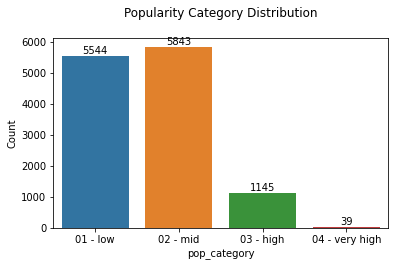

In [ ]:
# Function to ease the addition of labels to bar graphs
def add_value_labels(ax,labels):
  rects = ax.patches
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
  return ax
def tag_pop_category(play_df):
  conditions = [play_df['popularity'] <60, 
                (play_df['popularity'] >= 60) & (play_df['popularity'] < 75),
                (play_df['popularity'] >= 75) & (play_df['popularity'] < 90),
              play_df['popularity'] >= 90]

  values = [ '01 - low','02 - mid', '03 - high','04 - very high']
  play_df['pop_category'] = np.select(conditions, values)

  # Set data type as categorical
  play_df['pop_category'] = play_df['pop_category'].astype('category')
  return play_df


play_df = tag_pop_category(play_df)

tag_grp = play_df.value_counts('pop_category').reset_index().rename(columns={0:'Count'}).sort_values(by='pop_category')

fig = plt.figure(figsize=(6,3.5))
ax = plt.axes()

ax = sns.barplot(x='pop_category',y='Count',data=tag_grp)
ax.set_title('Popularity Category Distribution\n')
ax.set_ylabel('Count')
ax.set_xlabel('pop_category')

add_value_labels(ax,tag_grp['Count'])
plt.grid(False)
plt.show()


## Outlier Removal
In this section we examine the extent to which outliers are present in the dataset using a boxplot.  After examination, and upon finding outliers, a data cleaning methodology was implemented.  A function was created with the following steps:
* Determine the .25 quartile of the data within a given column (using np.quantile).  We call this variable 'Q1'.
* Determine the .75 quartile of the data within a given column (using np.quantile).  We call this variable 'Q3'.
* Calculate the IQR as: IQR = Q3 - Q1
* Calculate an upper bound: UB = Q3 + IQR * 1.5
* Calculate a lower bound: LB = Q1 - IQR * 1.5
* Use np.where() to replace high and low outliers with upper bound, and lower bound, respectively.


In [ ]:
# Create list with features that will require outlier removal & to use within different functions
slim_feature_lst = ['acousticness','danceability','energy','liveness','loudness','speechiness','valence','instrumentalness']
feature_lst = slim_feature_lst + ['tempo']

__Normalize_col(arg,arg)__:

This function is a scaling algorithm that is targeted at specific features.
this puts all of the targeted data on a scale of 0 to 100 so that we 
can easily visualize them on a box plot.

Arguments:
- Dataframe - `play_df`

Returns:
- Normalized/cleaned dataframe
- Plots two boxplots showing outliers prior to normalization and the cleaned dataframe post-normalization



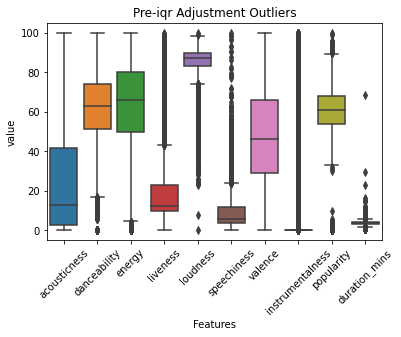

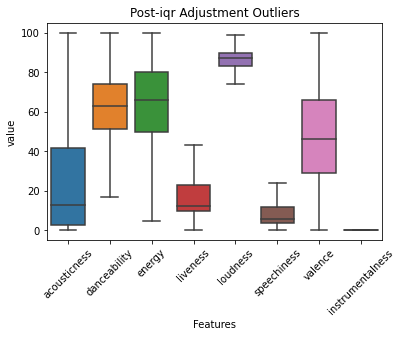

In [ ]:

def normalize_col(df,slim_feature_lst):
  for col in slim_feature_lst:
    df[col] = 100 *(df[col] - df[col].min())/(df[col].max() - df[col].min())

  pre_df = df.copy()

  for col in slim_feature_lst:
    q1 = np.quantile(df[col], .25)
    q3 = np.quantile(df[col], .75)
    iqr = q3 - q1
    col_upper = q3 + 1.5 * iqr
    col_low = q1 - 1.5 * iqr
    df[col] = np.where(df[col] > col_upper, col_upper, df[col])
    df[col] = np.where(df[col] < col_low, col_low, df[col])
  
  post_df = df.copy()

  #visualize outliers using boxplot
  sns.boxplot(x='variable', y='value', data=pd.melt(pre_df[slim_feature_lst + ['popularity','duration_mins']]))
  plt.xticks(range(len(slim_feature_lst) + 2),slim_feature_lst + ['popularity','duration_mins'], rotation = 45)
  plt.xlabel('Features')
  plt.title('Pre-iqr Adjustment Outliers')
  plt.show()

  print('\n')
  # Visualize data after cleaning
  sns.boxplot(x='variable', y='value', data=pd.melt(post_df[slim_feature_lst]))
  plt.xticks(range(len(slim_feature_lst)),slim_feature_lst, rotation = 45)
  plt.xlabel('Features')
  plt.title('Post-iqr Adjustment Outliers')
  plt.show()
  return post_df

# Generate dataframe prior to iqr based cleaning and post iqr cleaning
play_df = normalize_col(play_df,slim_feature_lst)

##Check updated data set
- Confirm that null values have been removed and check descriptive statistics of dataset

In [ ]:
# Check null values
print('Number of fields with null values --> ' + str(len([i for i in play_df.isnull().sum() if i > 0])))

Number of fields with null values --> 0


In [ ]:
play_df.shape

(12571, 19)

In [ ]:
# Print descriptive statistics
play_df.describe().T

,count,mean,std,min,25%,50%,75%,max
popularity,12571.0,60.995068,10.774073,0.000000,54.000000,61.000000,68.000000,100.000000
year,12571.0,2013.915520,3.696311,2008.000000,2011.000000,2014.000000,2017.000000,2020.000000
acousticness,12571.0,25.633157,28.779505,0.000000,2.520080,13.052209,41.716867,100.000000
danceability,12571.0,61.977886,16.716803,16.802860,51.276813,62.921348,74.259448,100.000000
energy,12571.0,63.457265,21.413459,4.598082,49.898993,66.199321,80.099600,100.000000
instrumentalness,12571.0,0.022369,0.036380,0.000000,0.000000,0.000134,0.035300,0.088250
key,12571.0,5.198711,3.580439,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,12571.0,17.496305,11.078100,0.000000,9.767911,12.512614,23.107972,43.118063
loudness,12571.0,85.930945,5.129531,73.931840,83.319193,86.983520,89.577429,98.964783
speechiness,12571.0,9.023061,7.162519,0.000000,3.831579,5.578947,11.894737,23.989474


In [ ]:
play_df.dtypes

artist                object
genre               category
id                    object
popularity           float64
track_name            object
year                   int64
acousticness         float64
danceability         float64
energy               float64
instrumentalness     float64
key                  float64
liveness             float64
loudness             float64
speechiness          float64
tempo                float64
time_signature       float64
valence              float64
duration_mins        float64
pop_category        category
dtype: object

#3. Begin Analysis
##Test Correlations Between Features
1. __High__ correlation between a predictor and the target is __preferred__ - we use the correlation as the agent of _relatedness_ between the two;
2. __Low__ correlation between a pair of predictors is __preferred__ - if you include a pair of highly correlated predictors in the same model, it would cause a problem of _auto-correlation_ or _multi-collinearality_, which would negatively impact the model performance.

------------

__plot_feautre_cor_heatmap(arg)__:

Argument:
- Dataframe - `play_df`

Returns:
- Void function to plot heatmap to show correlations between all available features


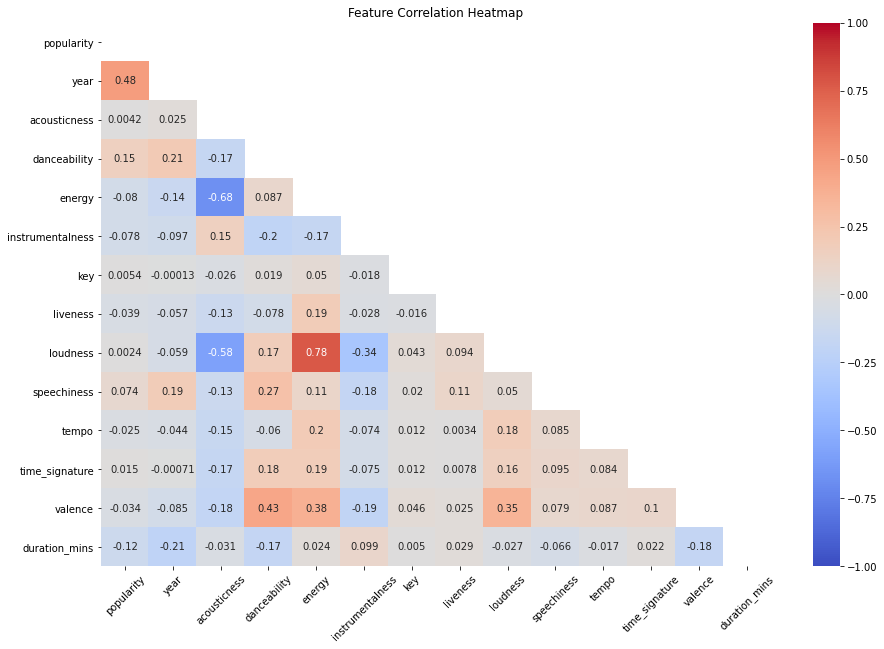

In [ ]:
def plot_feature_cor_heatmap(play_df):
  # define dataframe with feature correlations
  cor = play_df.corr()

  # Remove redundant correlations
  mask = np.zeros_like(cor, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # plot heatmap
  fig = plt.figure(figsize=(15,10))
  ax = plt.axes()
  ax = sns.heatmap(cor, vmin=-1,vmax=1,annot=True, cmap='coolwarm', mask=mask)
  ax.set_title('Feature Correlation Heatmap')
  ax.set_yticklabels(cor.columns)
  ax.set_xticklabels(cor.columns,rotation='45')

  plt.show()
  return None

# Plot feature correlation heatmap
plot_feature_cor_heatmap(play_df)

##Plot Correlations of Features vs Popularity
---------------------
__plot_feat_vs_pop_heatmap(arg)__

Arguments:
- Dataframe - `play_df`

Returns:
- Void function to plot heatmap showing correlation of all features against `popularity`

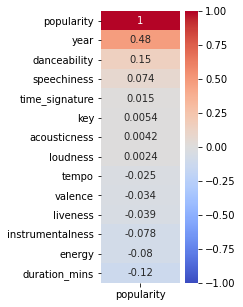

In [ ]:
def plot_feat_vs_pop_heatmap(play_df):
  target_corr = play_df.corr().sort_values(by='popularity',ascending = False)[['popularity']]
  fig = plt.figure(figsize = (6, 5))
  ax = plt.axes()
  plt.subplot(1,3,1)
  plt.subplot(sns.heatmap(target_corr, vmin = -1, vmax = 1,
            cmap = 'coolwarm',
            annot = True))
  return None

# Plot feature vs popularity correlation heatmap
plot_feat_vs_pop_heatmap(play_df)

#Test correlation of relevant features against popularity
-----------------
__plot_feat_vs_pop(arg)__:

<u>Arguments</u>: 

Dataframe - `play_df`

<u>Returns</u>:

Void function to plot bargraph
  - X Axis - `pop_category`
  - Y Axis - Average feature value

------------

Feature|Correlation to Popularity
-------|-----------
Acousticness|Negative
Danceability|Positive
Enegry|Neutral
Liveness|Negative
Loudness|Neutral
Speechiness|Positive
Valence|Positive
Tempo|Neutral




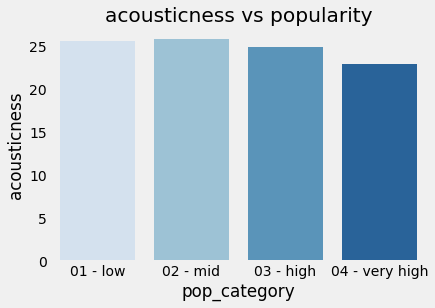

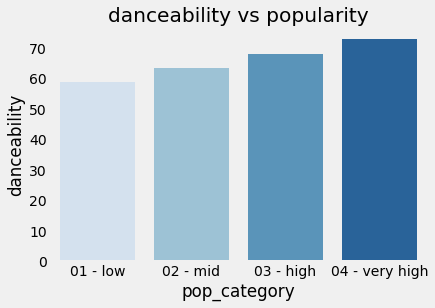

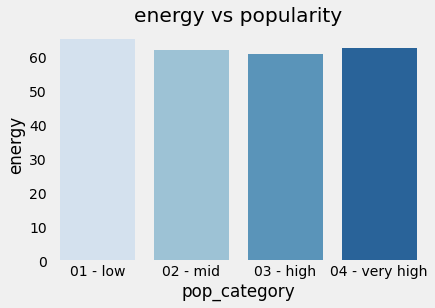

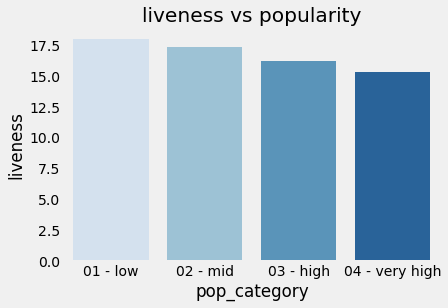

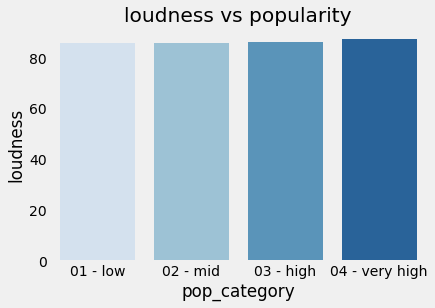

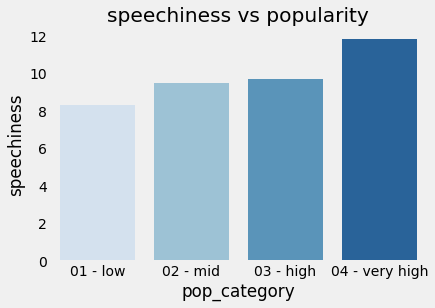

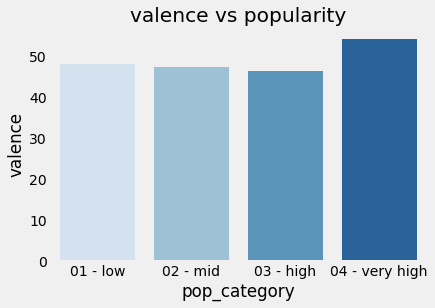

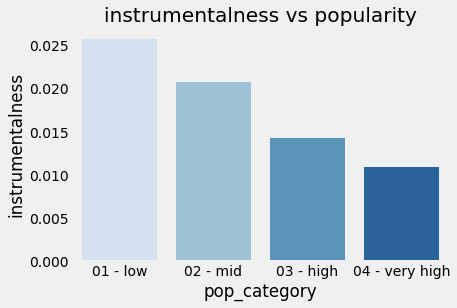

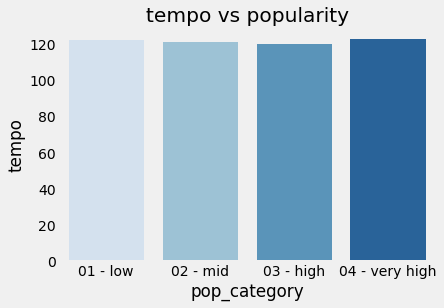

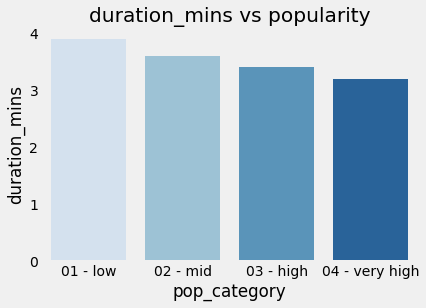

In [ ]:
def plot_feat_vs_pop(play_df,feature_lst):
  # Set configurations for bar graphs
  plt.style.use('fivethirtyeight')
  index = 'pop_category'

  # Loop through features to display plots against popularity
  for column in feature_lst:
    fig = plt.figure(figsize=(6,4))
    ax = plt.axes()
    plt.grid(False)
    piv_df = play_df.pivot_table(column, index = index, aggfunc = np.mean)
    sns.barplot(x=piv_df.index, y=piv_df[column],data=piv_df,palette='Blues')
    plt.xlabel('pop_category')
    plt.ylabel(column)
    plt.title(column +' vs popularity')
    plt.show()
    print('\n')
  return None

# Plot feature vs popularity bar graphs
plot_feat_vs_pop(play_df,feature_lst + ['duration_mins'])

#Testing by genre
-----------------
__plot_pop_by_genre(arg)__:

Argument:
- Dataframe - `play_df`

Returns:
- Void function to plot horizontal bar chart showing the average popularity value by country 

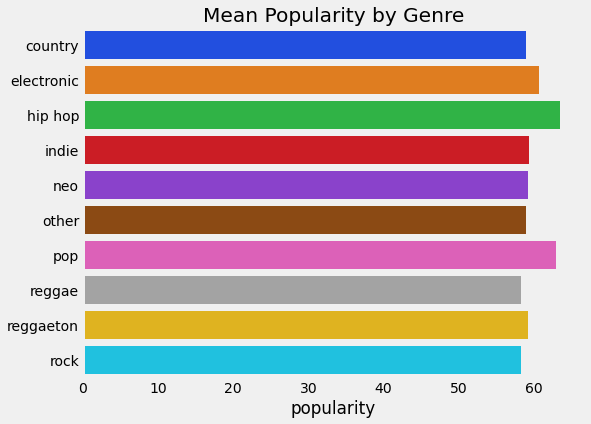

In [ ]:
def plot_pop_by_genre(play_df):
  # Group data set by Genre
  genre_grp = play_df.groupby('genre').agg({'popularity':'mean'})
    
  # Display horizontal bar plot
  fig = plt.figure(figsize = (8, 6))
  sns.barplot(x=genre_grp['popularity'], y=list(genre_grp.index), data=genre_grp, orient='h',palette='bright')
  plt.grid(False)
  plt.title('Mean Popularity by Genre')
  plt.show()
  return None

# Display mean popularity by genre
plot_pop_by_genre(play_df)

# Feature Correlations by Genre
------------
After our initial analysis of how popularity correlates with the various features within our dataset, we decided to go on dimension deeper and look at the same correlations aggregated by genres. 

Our hypothesis was that some features would have stronger correlations with popularity when compared to similar types of music. For example, we thought that Rock or Country songs would have strong correlation between popularity and instrumentallness. 

The only impactful changes in correlations were seen within the Reggae genre, but this genre only contains 70 samples within our data set, while other genres hold +2,000 samples. This brings us to the conclusion that our initial correlation analysis is not improved by grouping our data by genre.

--------------

__plot_cor_by_genre(arg)__:

Argument:
- Dataframe - `play_df`

Returns:
- Void function to plot horizontal heatmap showing the feature correlations against `popularity`, aggregated by genre.



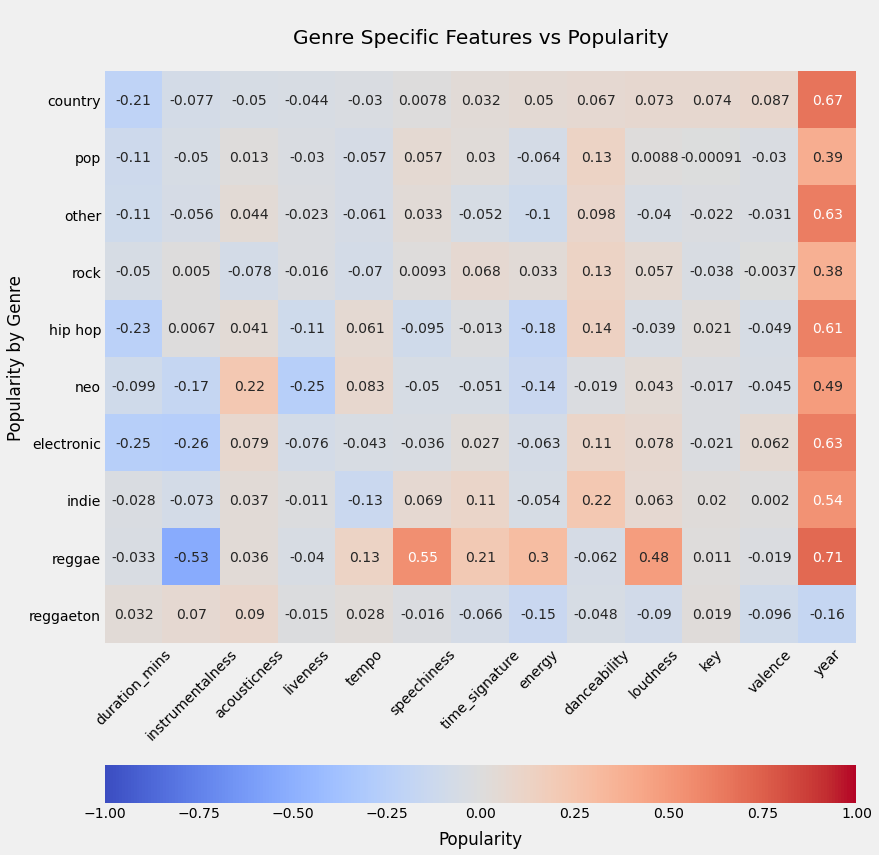

In [ ]:
def plot_cor_by_genre(play_df):
  # Generate list with all available genre tags
  genre_lst = play_df['genre'].unique().tolist()

  # append horizontal correlation dataframes
  genre_heatmap = pd.DataFrame()
  for genre in genre_lst:
    genre_df = play_df.loc[play_df['genre'] == genre].corr().sort_values(by='popularity',ascending =  True)[['popularity']].T.reset_index(drop=True)
    genre_df.index = [genre]
    genre_heatmap = genre_heatmap.append(genre_df)

  # Drop popularity from the correlation test
  genre_heatmap = genre_heatmap.drop(['popularity'],axis=1)

  # Plot horizontal feature correlations against popularity by genre
  fig = plt.figure(figsize = (12, 14))
  ax = plt.axes()
  ax = sns.heatmap(genre_heatmap, vmin = -1, vmax = 1,cmap = 'coolwarm',annot = True,cbar_kws={"orientation": "horizontal"})
  ax.set_title('\nGenre Specific Features vs Popularity\n')
  ax.set_xticklabels(genre_heatmap.columns,rotation=45)
  ax.set_xlabel('\n\n\n\nPopularity')
  ax.set_ylabel('Popularity by Genre')
  plt.show()
  return None

# Generate genre specific heatmap
plot_cor_by_genre(play_df)

# Machine Learning

The 3 highest correlated features were sliced and sent to a csv format for machine learning.  The target features were twofold.  For prediction algorithms, the continous feature, popularity, was targeted.  For the classification algorithm, the popularity category feature, one that was created using np.select, was targeted.

The following machine learning widget was used:

[Wolfram Machine Learning for Small Datasets](https://www.wolframcloud.com/obj/philip/ai)

Several prediction algorithms were utilized, and the results were as follows:

## Performance Matrix - Prediction
| Algorithm | Mean Avg Dev (MAD) |
| -------------- | -------------- |
| Guassian Process | 8.14 |
| Naive (Average) | 8.06 |
| Neural Network | 7.80 |
| Nearest Neighbors | 7.79 |
| Decision Tree | 7.74 |
| Grad Boosted Tree | 7.65 |
| Random Forest | 7.01 |
| Linear Regression | 6.63 |





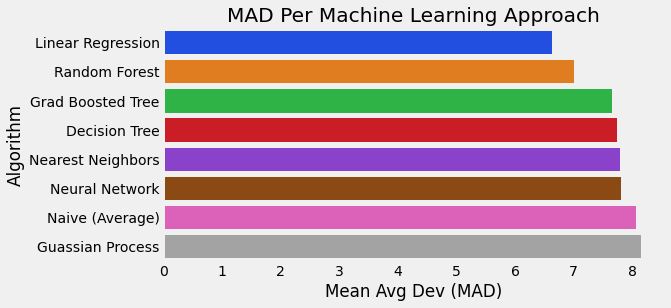

In [ ]:
def plot_ml_results():
  ml = pd.DataFrame({'Algorithm':['Naive (Average)','Decision Tree','Grad Boosted Tree','Linear Regression',
                                  'Nearest Neighbors','Neural Network','Random Forest','Guassian Process'],
                      'Mean Avg Dev (MAD)':[8.06,7.74,7.65,6.63,7.79,7.80,7.01,8.14]}).sort_values(by='Mean Avg Dev (MAD)')

  fig = plt.figure(figsize=(8,4))
  ax = plt.axes()
  ax = sns.barplot(x='Mean Avg Dev (MAD)',y='Algorithm',data=ml,orient='h',palette='bright')
  ax.set_title('MAD Per Machine Learning Approach')
  plt.grid(False)
  plt.show()
plot_ml_results()

### Machine Learning Performance over iterations
In this area we look at how the machine learning "learns" as it iterates through the dataset.  This is achieved by plotting the running MAD vs the iteration.

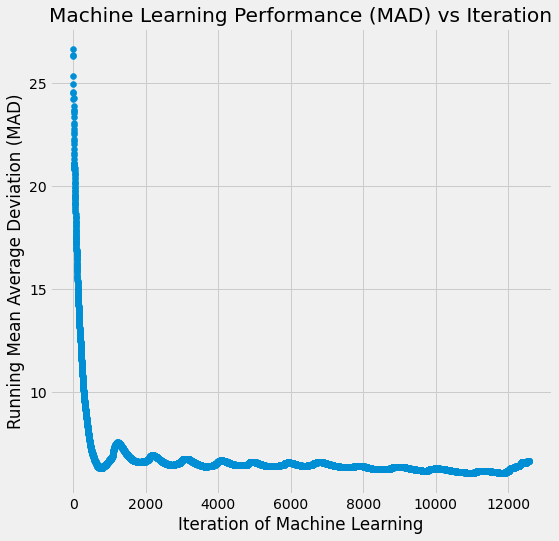

In [ ]:
def plot_ml_MAD():
  ml_iter = pd.read_csv(os.path.join(base_dir,'ml_df3-prediction-lin-regression-performance.csv'),encoding='cp1252')
  fig = plt.figure(figsize = (8,8))
  ax = plt.scatter(ml_iter['iteration'], ml_iter['Running MAD'])
  plt.xlabel('Iteration of Machine Learning')
  plt.ylabel('Running Mean Average Deviation (MAD)')
  plt.title('Machine Learning Performance (MAD) vs Iteration')
  return None
plot_ml_MAD()

## Classification Results

Additionally, a classification algorithm was used to predict the popularity category (very high, high, medium, low).  The decision tree algorithm was used, and it predicted correctly __80.6%__ of the time.  Below you can see the plotted prediction accuracy vs iteration.

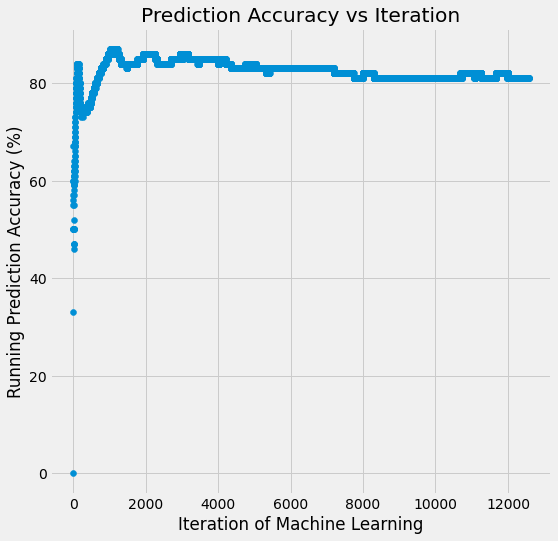

In [ ]:
def plot_pred_acc():
  class_iter = pd.read_csv(os.path.join(base_dir,'ml_df-class-decision tree performance.csv'),encoding='cp1252')
  class_iter['Running Prediction Accuracy'] = class_iter['Running Prediction Accuracy'] * 100
  fig = plt.figure(figsize = (8,8))
  ax = plt.scatter(class_iter['Iteration'], class_iter['Running Prediction Accuracy'])
  plt.xlabel('Iteration of Machine Learning')
  plt.ylabel('Running Prediction Accuracy (%)')
  plt.title('Prediction Accuracy vs Iteration')
  return None
plot_pred_acc()

#Function to pull image of top song by year


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  



Bad Bunny - Dakiti


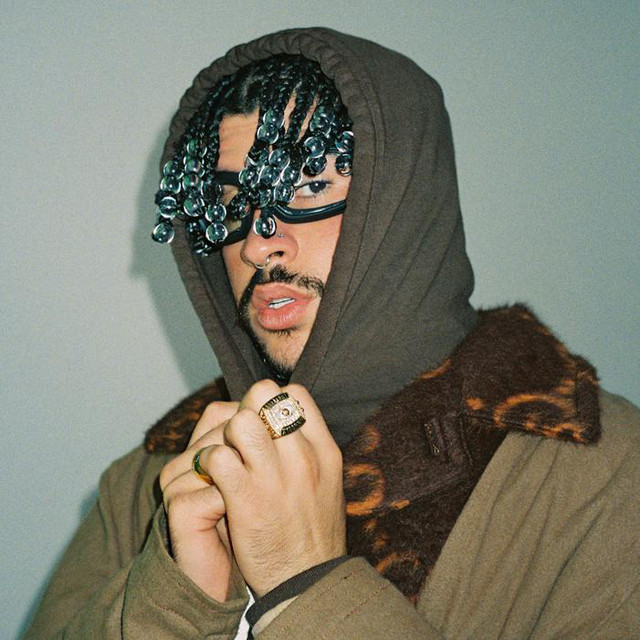

In [ ]:
def get_img(spot_df,year=2020):
  # Configurations
  from spotipy.oauth2 import SpotifyClientCredentials
  from IPython.display import Image; import urllib.request; 
  CLIENT_ID = '0334096aa9004802afe7d5caf79aeb95'
  CLIENT_SECRET = 'd5e962e82f834f068269378209c5f83e'
  token = spotipy.oauth2.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
  cache_token = token.get_access_token()
  sp = spotipy.Spotify(cache_token)
  if not isinstance(year,str):
    year = str(year)
  if not year.isnumeric() & len(year) != 4:
    raise ValueError('Please pass a 4 digit year')
  if int(year) not in list(range(2008,2021)):
    raise ValueError('Please pass a year between 2008 - 2020')

  spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET))

  top_song = raw_data.loc[raw_data['year'].isin([year])]
  top_song = top_song.loc[top_song['popularity'].isin([max(top_song['popularity'])])] 

  top_song['artist_song'] = top_song['artist'] + ' - ' + top_song['track_name']

  artist_song = top_song['artist_song'].tolist()[0]
  name = top_song['artist'].tolist()[0]

  results = spotify.search(q='artist:' + name, type='artist')
  items = results['artists']['items']

  if len(items) > 0:
    artist = items[0]['images']
    image_url = [i['url'] for i in artist][0]
    urllib.request.urlretrieve(image_url, name + '.png')
    print('\n' + str(artist_song))
  
  return Image(name + '.png', width=300, height=300)

"""
If we have time, can anyone guess the top song for a year between 2008 - 2020?
"""
get_img(play_df)